In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scienceplots
%matplotlib inline

from nanonets.utils import prepare_for_fitness_calculation, fitness, abundance, abundance_plot, get_best_logic_gate, nonlinear_parameter, return_ndr, return_nls

PATH    = "/home/jonasmensing/bagheera/data/2_funding_period/static/res_disorder/"
PATH_U  = "/home/jonasmensing/bagheera/data/1_funding_period/system_size_scaled/"
V_IN    = 0.01
DELTA   = 0.01
MAX_ERROR = 0.1
GATES   = ['AND', 'OR', 'XOR', 'NAND', 'NOR', 'XNOR']
plt.style.use(["science","bright","grid"])

In [5]:
data    = {}
df_u    = pd.read_csv(f"{PATH_U}Nx=9_Ny=9_Ne=8.csv")
df_u    = df_u[(df_u['Error']/df_u['Observable']).abs() < MAX_ERROR].reset_index(drop=True)
df_u    = prepare_for_fitness_calculation(df_u, N_e=8, input_cols=["E1","E3"])
df_dis  = pd.DataFrame()
for i in range(64):
    df      = pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8mean2_50.0_{i}.csv")
    df      = df[(df['Error']/df['Observable']).abs() < MAX_ERROR].reset_index(drop=True)
    df      = prepare_for_fitness_calculation(df, N_e=8, input_cols=["E1","E3"])
    df_dis  = pd.concat((df_dis,df),ignore_index=True)
    data[i] = df

In [6]:
fitness_data_u      = fitness(df_u, input_cols=["E1","E3"], on_state=0.01, delta=DELTA)
abundance_data_u    = abundance(fitness_data_u)
fitness_data_dis    = fitness(df_dis, input_cols=["E1","E3"], on_state=0.01, delta=DELTA)
abundance_data_dis  = abundance(fitness_data_dis)
fitness_data        = {key : fitness(df, input_cols=["E1","E3"], on_state=0.01, delta=DELTA) for key, df in data.items()}
abundance_data      = {key : abundance(df) for key, df in fitness_data.items()}

In [7]:
df1 = fitness_data_dis.loc[:,'AND Fitness':]
df1.columns = GATES
df1 = df1.melt(var_name='Gate', value_name='$Fitness$')
df1['Disorder'] = True

df2 = fitness_data_u.loc[:,'AND Fitness':]
df2.columns = GATES
df2 = df2.melt(var_name='Gate', value_name='$Fitness$')
df2['Disorder'] = False

fitness_melted = pd.concat([df1,df2],ignore_index=True)
fitness_melted

,Gate,$Fitness$,Disorder
0,AND,9.398278,True
1,AND,1.351152,True
2,AND,6.300581,True
3,AND,1.803353,True
4,AND,17.134290,True
...,...,...,...
417493,XNOR,0.002194,False
417494,XNOR,-0.009091,False
417495,XNOR,0.082449,False
417496,XNOR,0.282562,False


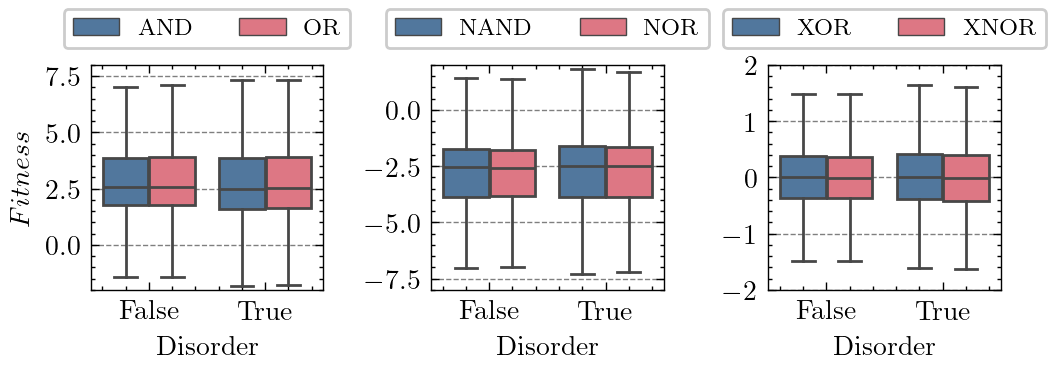

In [8]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*0.7)

for i, g_comb in enumerate([['AND','OR'],['NAND','NOR'],['XOR','XNOR']]):

    ax  = fig.add_subplot(1,3,i+1)
    ax  = sns.boxplot(data=fitness_melted[(fitness_melted['Gate']==g_comb[0])|(fitness_melted['Gate']==g_comb[1])],
                      x='Disorder', y='$Fitness$', hue='Gate', ax=ax, fliersize=0)
    leg = ax.legend(loc='center', bbox_to_anchor=(0.5,1.16), ncol=2, fontsize='small')
    leg.set_in_layout(True)
    if i != 0:
        ax.set_ylabel("")
    if i == 0:
        ax.set_ylim(-2,8)
    elif i == 1:
        ax.set_ylim(-8,2)
    else:
        ax.set_ylim(-2,2)

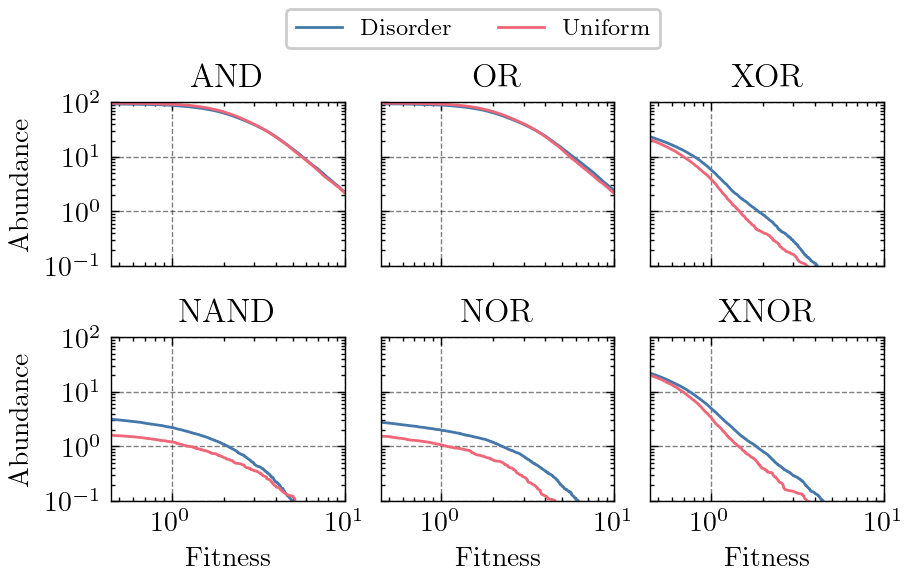

In [9]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.3)

for i, gate in enumerate(GATES):
    
    ax     = fig.add_subplot(2,3,i+1)
    x1, y1 = abundance_data_dis[f'{gate} Fitness'], abundance_data_dis[f'{gate} Fitness Abundance']
    x4, y4 = abundance_data_u[f'{gate} Fitness'], abundance_data_u[f'{gate} Fitness Abundance']

    ax.plot(x1,y1, label='Disorder')
    ax.plot(x4,y4, label='Uniform')

    ax.set_xlim(0.45,10)
    ax.set_ylim(0.1,100)
    ax.set_yscale('log')
    ax.set_xscale('log')

    if i % 3 == 0:
        ax.set_ylabel("Abundance")
    else:
        ax.set_yticklabels("")
    if i >= 3:
        ax.set_xlabel("Fitness")
    else:
        ax.set_xticklabels("")
    ax.set_title(gate)

    if i==0:
        leg = ax.legend(loc='center', bbox_to_anchor=(1.55,1.45), ncol=6, fontsize='small')

leg.set_in_layout(False)
fig.canvas.draw()
leg.set_in_layout(True)
fig.set_layout_engine('none')

In [10]:
# Current Relations
n_bootstrap = 100
params      = [nonlinear_parameter(df, on_state=0.01, n_bootstrap=n_bootstrap) for df in [df_dis, df_u]]

# NDR / NLS
bins    = 'fd'
Q_ndr   = []
Q_nls   = []
for i in range(n_bootstrap): 

    Q_ndr_l =   np.array([return_ndr(params[n][i]['Ml']) for n in range(2)])
    Q_ndr_r =   np.array([return_ndr(params[n][i]['Mr']) for n in range(2)])
    Q_ndr.append((Q_ndr_l + Q_ndr_r) / 2)

    Q_nls.append(np.array([return_nls(df=params[n][i], bins=bins) for n in range(2)]))

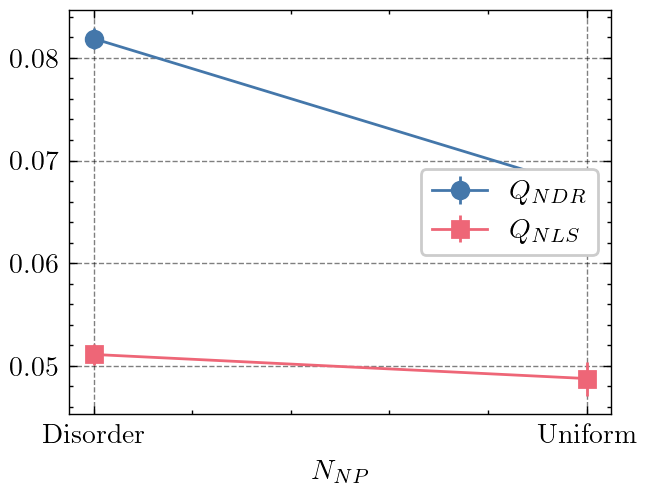

In [11]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    
    ax.errorbar(['Disorder','Uniform'], np.mean(Q_ndr,axis=0), 1.96*np.std(Q_ndr,axis=0), marker='o', label='$Q_{NDR}$')
    ax.errorbar(['Disorder','Uniform'], np.mean(Q_nls,axis=0), 1.96*np.std(Q_ndr,axis=0), marker='s', label='$Q_{NLS}$')

    ax.set_xlabel('$N_{NP}$')
    ax.legend(loc='center right')
    # ax.set_ylim(0.1,0.5)

# fig.savefig("../plots/scaled_nonlinearity_vs_system_size_scaled.svg", transparent=True, bbox_inches='tight')
# fig.savefig("../plots/scaled_nonlinearity_vs_system_size_scaled.pdf", transparent=False, bbox_inches='tight')

In [12]:
df_comp = pd.DataFrame()
for i in range(64):
    df1 = fitness_data[i].loc[:,'AND Fitness':]
    df1.columns = GATES
    df1 = df1.melt(var_name='Gate', value_name='$Fitness$')
    df1['Disorder'] = i
    df_comp = pd.concat((df_comp,df1),ignore_index=True)

df1 = fitness_data_u.loc[:,'AND Fitness':]
df1.columns = GATES
df1 = df1.melt(var_name='Gate', value_name='$Fitness$')
df1['Disorder'] = -1

df_comp = pd.concat([df_comp, df1], ignore_index=True)
df_comp

,Gate,$Fitness$,Disorder
0,AND,9.398278,0
1,AND,1.351152,0
2,AND,6.300581,0
3,AND,1.803353,0
4,AND,17.134290,0
...,...,...,...
417493,XNOR,0.002194,-1
417494,XNOR,-0.009091,-1
417495,XNOR,0.082449,-1
417496,XNOR,0.282562,-1


Text(0.5, 0, '$\\sigma_F$')

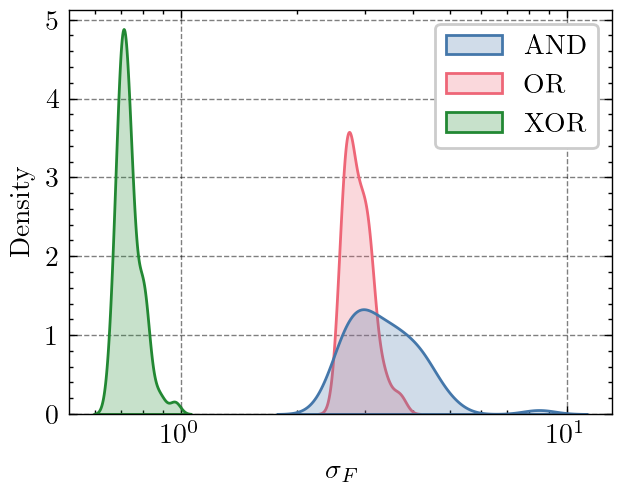

In [13]:
df = pd.DataFrame([[fitness_data[i][f'{gate} Fitness'].std() for i in range(64)] for gate in ['AND','OR','XOR']]).T
df.columns = ['AND','OR','XOR']
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.kdeplot(df, ax=ax, log_scale=True, fill=True)
ax.set_xlabel("$\sigma_F$")

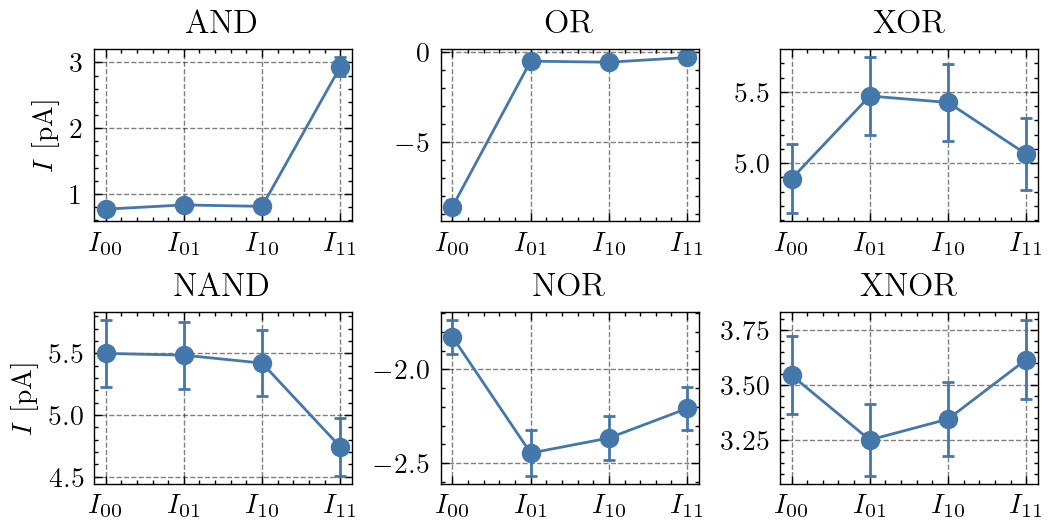

In [15]:
n   = 12
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
for i, gate in enumerate(GATES):
    ax = fig.add_subplot(2,3,i+1)
    best_gate = get_best_logic_gate(data[n], fitness_data[n], gate)
    ax.errorbar([0,1,2,3], best_gate['Observable'].values*1e-6, best_gate['Error'].values*1e-6, marker='o', capsize=2)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(["$I_{00}$","$I_{01}$","$I_{10}$","$I_{11}$"])
    ax.set_title(gate)
    if i % 3 == 0:
        ax.set_ylabel("$I$ [pA]")